# Set subject model.

In [4]:
#must be unique.
model_name = 'exp_model'
epoch_select = 1000

# Imports and model init

In [5]:
#imports

import torch
import matplotlib.pyplot as plt
import numpy as np
import time, os, pickle
import pandas as pd


import init
import loader
import visualisation
import parameters
import ipynb_utils
import sys
from serial import RNN
from b_vae import B_VAE
from autoencoders import vae
import matplotlib.colors as colors
import matplotlib.cm as cmx
sys.path.append('../../libs/')
import shjnn

# Initalize Model




# Load the model
saves_folder = "saves"
model_subfolder = None

if os.path.exists(saves_folder):
    for subfolder in os.listdir(saves_folder):
        subfolder_path = os.path.join(saves_folder, subfolder)
        if os.path.isdir(subfolder_path) and model_name in subfolder:
            model_subfolder = os.path.join(subfolder_path, "model")
            break

# Check for Pickle and PTH files
pickle_file = None
pth_files = []
for file in os.listdir(model_subfolder):
    if file.endswith(".pkl"):
        pickle_file = os.path.join(model_subfolder, file)
        print(f"(1/4) Found Config file: {pickle_file}")
        
    elif file.endswith(".pth"):
        pth_file = os.path.join(model_subfolder, file)
        pth_files.append(pth_file)
if not pickle_file or not pth_files:
    print(f"Pickle file or PTH file not found in '{model_subfolder}'.")
    raise FileNotFoundError(f"Pickle file or PTH file not found in '{model_subfolder}'.")

if pth_files:
    print(f"(2/4) Found Model Saves")
# Load the model configuration
loaded = None
with open(pickle_file, 'rb') as f:
    try:
        loaded = pickle.load(f)
    except EOFError:
        pass
assert len(loaded) == 17


parameters.dataset = loaded[0]
parameters.dataset_PV = loaded[1]
parameters.trainer = loaded[2]
parameters.model = loaded[3]
parameters.rnn = loaded[4]
parameters.b_vae = loaded[5]
parameters.load_check = loaded[6]
parameters.model_params = loaded[7]
parameters.vae_params = loaded[8]
parameters.records = loaded[9]
parameters.device = loaded[10]
parameters.amp = loaded[11]
parameters.freq = loaded[12]
parameters.adaptive_training = loaded[13]
parameters.save = loaded[14]
parameters.split = loaded[15]
parameters.gridsearch = loaded[16]

assert parameters.load_check == True
print(f"(3/4) Loaded Config")

#load the model.
model_params = parameters.model_params
dev = torch.device(parameters.device)
if epoch_select is None:
    path = pth_files[-1]  # Use the last file in the list
else:
    path = [f for f in pth_files if f"{epoch_select}" in f]
    if not path:
        raise FileNotFoundError(f"No PTH file found for epoch {epoch_select}.")
    path = path[0]
assert model_params['func'] is not None
try:
    import torch.serialization
    torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])
except (ImportError, AttributeError):
    pass
shjnn.load_state(path, model_params['func'], model_params['rec'], decoder = model_params['dec'], optimizer = model_params['optim'], loss = model_params['loss'], epochs = model_params['epochs'], dev = dev)
print(f"(4/4) Loaded Model from {path}")

print("---Success--- Model and parameters loaded successfully.")

(1/4) Found Config file: saves\20250609-195523_exp_model_3ld_6b_\model\parameters.pkl
(2/4) Found Model Saves
(3/4) Loaded Config
(4/4) Loaded Model from saves\20250609-195523_exp_model_3ld_6b_\model\save_model_ckpt_1000.pth
---Success--- Model and parameters loaded successfully.


# Raw Visualisations

check model performance.

In [6]:
# check performance
parameters.model.eval(parameters.model_params, parameters.dataset)

logs: b_vae: eval: evaluating over 150 samples.
logs: b_vae: eval: batch 1/10, avg loss: 1.789822
logs: b_vae: eval: batch 2/10, avg loss: 2.287434
logs: b_vae: eval: batch 3/10, avg loss: 1.971747
logs: b_vae: eval: batch 4/10, avg loss: 1.776841
logs: b_vae: eval: batch 5/10, avg loss: 2.119180
logs: b_vae: eval: batch 6/10, avg loss: 1.870892
logs: b_vae: eval: batch 7/10, avg loss: 2.057007
logs: b_vae: eval: batch 8/10, avg loss: 2.011422
logs: b_vae: eval: batch 9/10, avg loss: 1.903041
logs: b_vae: eval: batch 10/10, avg loss: 1.662185
logs: b_vae: eval: mean loss over 150 samples: 1.9638086422284444 at epoch 1000.


np.float64(1.9638086422284444)

Plots sweeps through the dataset along a specific axis.

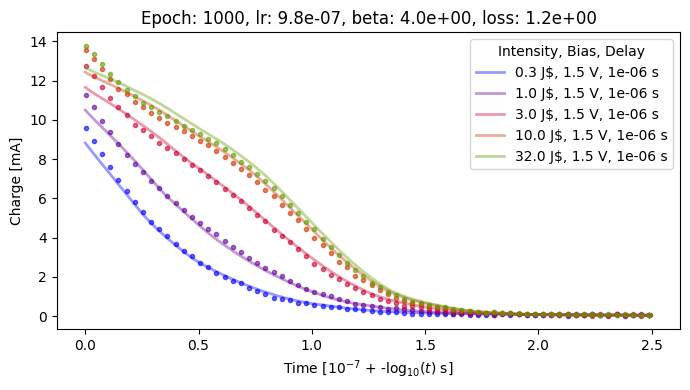

In [5]:
# Run model inference and visualisation along different parameters

# select models to plot ('intensity', 'voltage', or 'delay')
plot_models = ipynb_utils.get_sweep_index(122, 'intensity')  # Example: sweep based on intensity from the first index

parameters.model_params['plot'] = plot_models
visualisation.display_random_fit(parameters.model_params, parameters.dataset, show=True, save=False, random_samples=False)

# Assess mean performance of each of the properties

In [7]:
mean_map, mean_map_indices, mean_map_original_data = ipynb_utils.get_mean_trajectories(parameters.model_params, parameters.dataset)

Running inference on 150 trajectories...
Inference complete. Shapes - Predictions: (150, 1000, 1), Latent: (150, 1000, 3)


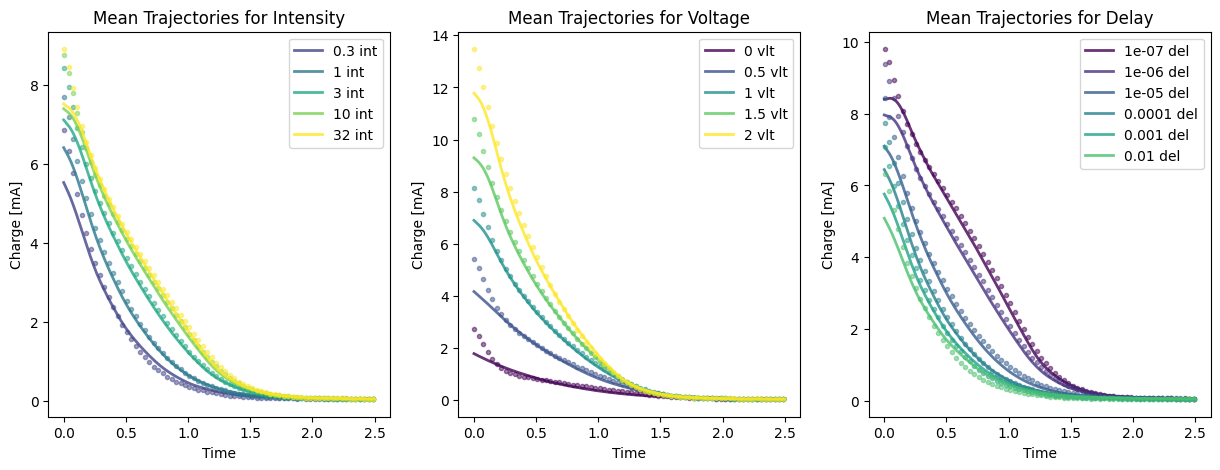

In [8]:
ipynb_utils.get_mean_property_plot(parameters.model_params, parameters.dataset, mean_map, mean_map_original_data, show=True)

# Latent Sectional Init -- run this first

In [9]:
latent, all = ipynb_utils.get_latent_vectors(model_params, parameters.dataset, traj_idx=None)

Latent vectors shape: (150, 3) All timesteps shape: (150, 1000, 3)


Plot Full Sweep latent dimensions

---Visualising Latent Dimension 0---


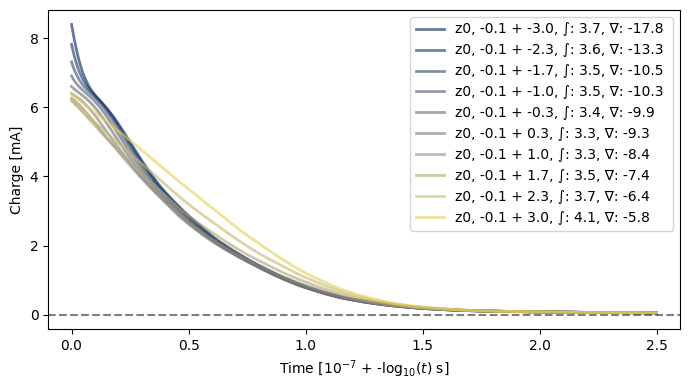

---Visualising Latent Dimension 1---


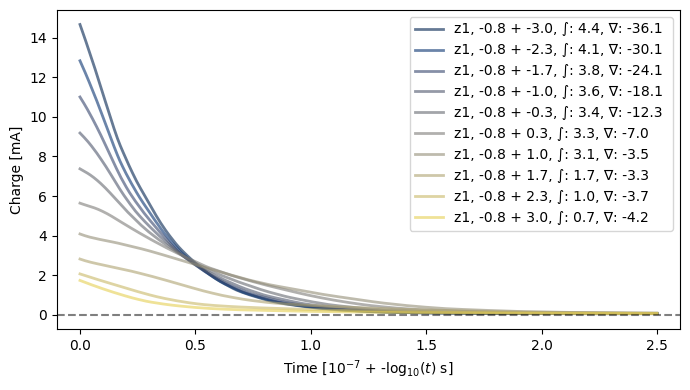

---Visualising Latent Dimension 2---


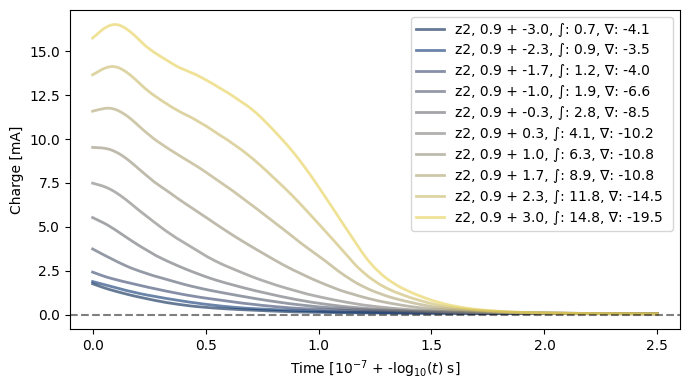

In [10]:
latent_variance = []
timestep_interest = 0     #always 0 unless exclusively calculating latent variance.

latent_subject = all[:, timestep_interest, :]    #all[traj_idx, timestep_interest, :], default is all[:,0,:] which will mean over all samples.
                                                       # timestep_interest should always be 0, unless this fn is only used for calculating latent_variance
for dim_idx in range(model_params['latent_dim']):
    print(f"---Visualising Latent Dimension {dim_idx}---")
    latent_variance.append(ipynb_utils.sweep_latent_adaptive(parameters.model_params, parameters.dataset, dim_idx, latent_subject, all, save=False, show=True, show_integrals=True))

Sort latent dims

In [30]:
#sort latent vectors by latent_variance
Y = torch.tensor(latent_variance, dtype=torch.float)
sorted_idxs = Y.argsort(descending=True)
latent_sorted = latent[:, sorted_idxs]
all_sorted = all[:,:,sorted_idxs]


---Visualising Latent Dimension 0---


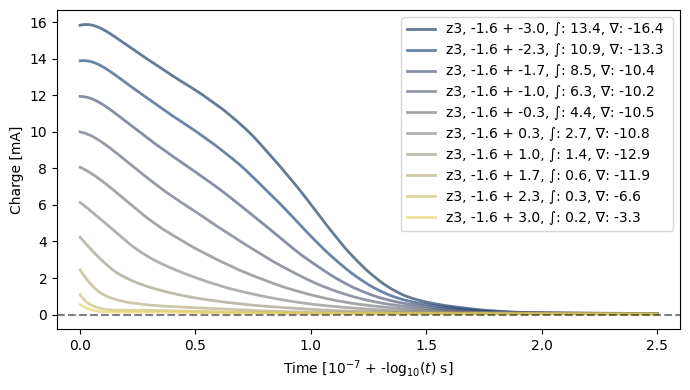

---Visualising Latent Dimension 1---


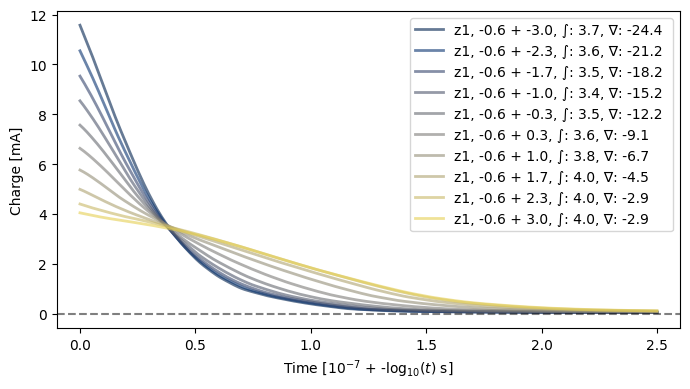

---Visualising Latent Dimension 2---


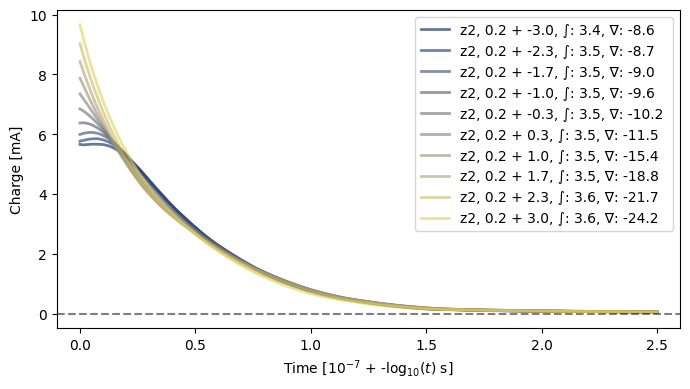

---Visualising Latent Dimension 3---


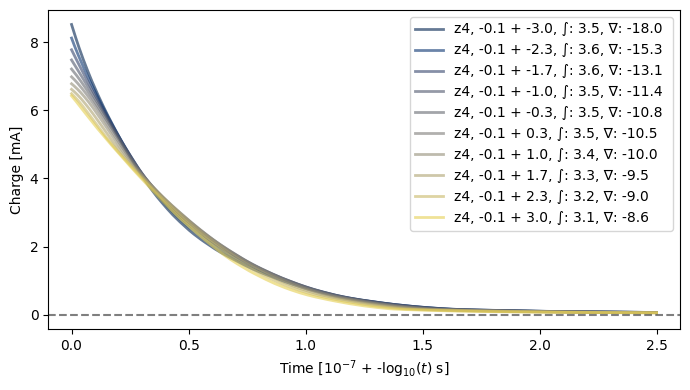

---Visualising Latent Dimension 4---


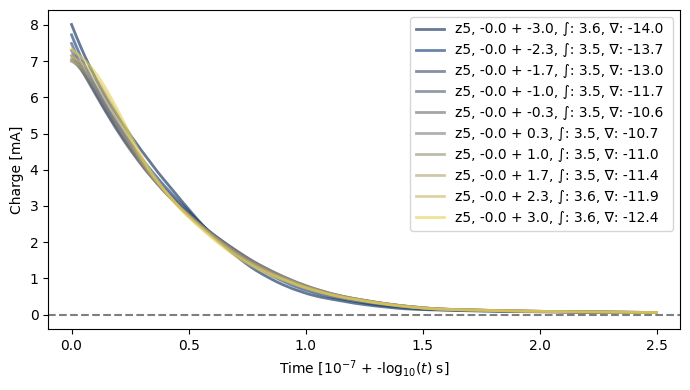

---Visualising Latent Dimension 5---


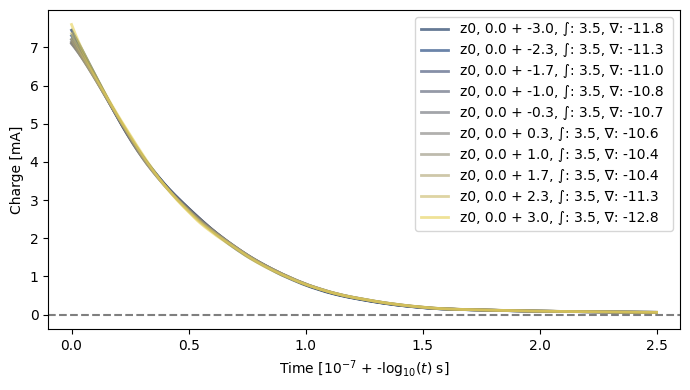

In [15]:
for i, dim_idx in enumerate(sorted_idxs):
    print(f"---Visualising Latent Dimension {i}---")
    ipynb_utils.sweep_latent_adaptive(parameters.model_params, parameters.dataset, dim_idx, latent_subject, all, save=False, show=True, show_integrals=True)

Time-series 

In [ ]:
# Test the time evolved sweep function
dim_idx = 0  # Example latent dimension
timesteps_of_interest = [0, 100, 200, 300, 400, 500, 600, 900, 999]  # Example timesteps to analyze (0 - 999)

print(f"---Visualising Time-Evolved Latent Dimension {dim_idx}---")
visualisation.time_evolved_sweep(
    parameters.model_params, 
    parameters.dataset, 
    dim_idx, 
    timesteps_of_interest, 
    save=False, 
    show=True
)

---Visualising Time-Evolved Latent Dimension 0---


KeyboardInterrupt: 

In [31]:
print(sorted_idxs)

tensor([1, 3, 4, 2, 5, 0])


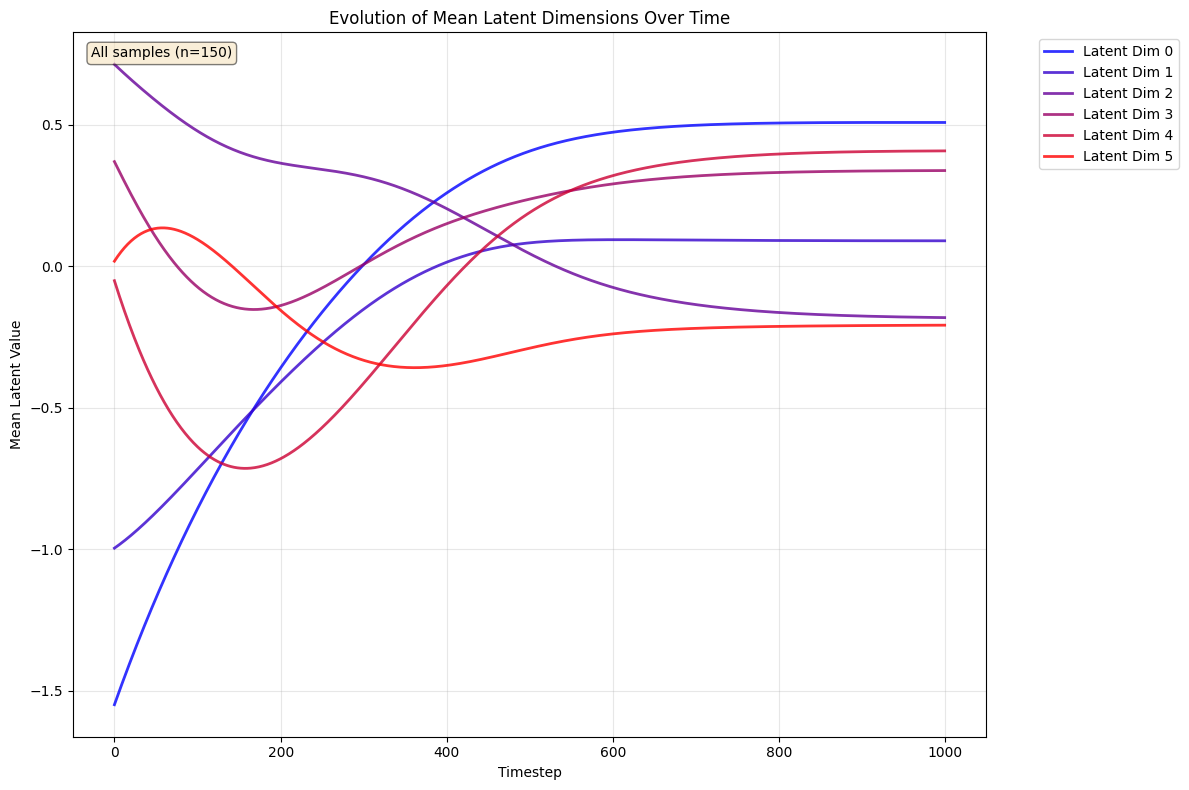

Plotted 6 latent dimensions over 1000 timesteps


In [45]:
# Plot latent trajectory evolution
# Show how all latent dimensions evolve over time

# Using all samples
ipynb_utils.latent_trajectory(all_sorted, sample_list=None, show=True, save=False)

# Example: Using only specific samples (e.g., first 10 samples)
# ipynb_utils.latent_trajectory(all, sample_list=list(range(10)), show=True, save=False)

Latent means analysis


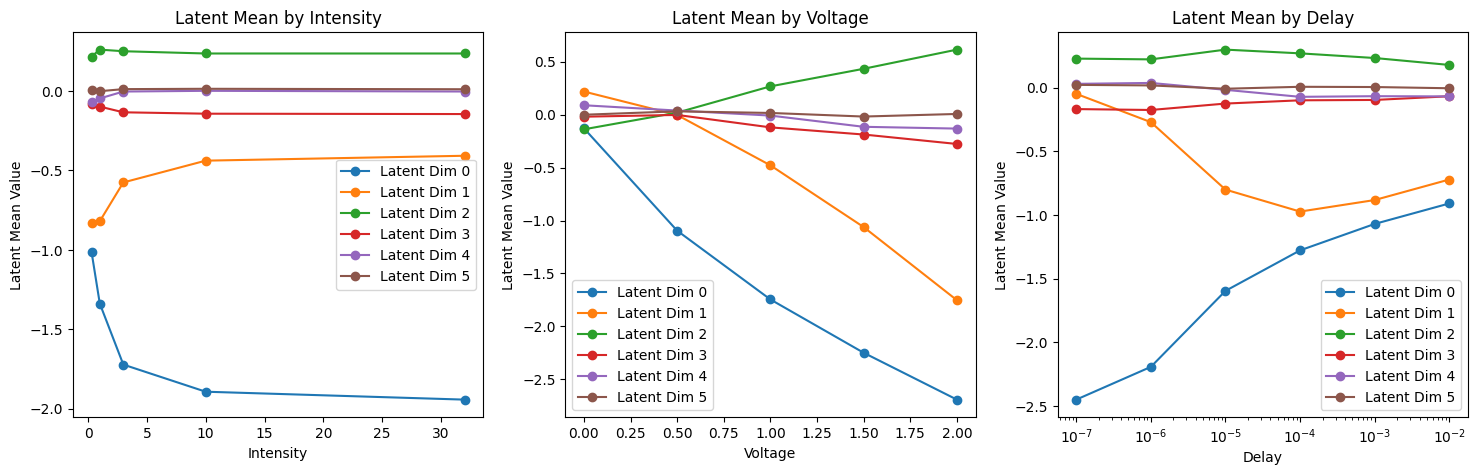

In [13]:
ipynb_utils.latent_means_for_parameter(mean_map_indices, latent_sorted)

Custom Latent Value Sweep

In [7]:
#init
model_params = parameters.model_params
infer_step_decode = shjnn.make_infer_step(
        model_params['func'], model_params['rec'], model_params['dec'], model_params['optim'], model_params['device'], 
        input_mode='latent'
    )
pred_times = np.linspace(0, 2.5, 1000)
time_tensor = torch.Tensor(pred_times).to(model_params['device'])
scale_factor = 50 * 1e2 / 1e3

In [ ]:


weights, bias = ipynb_utils.extract_linear_map(infer_step_decode, model_params, time_tensor)
print("Weights per latent dim:", weights)
print("Bias term:", bias)

Weights per latent dim: [ 5.4807663e-03 -1.0978054e+01  3.3715811e+00 -8.2780237e+00
  5.5566101e+00 -6.3049841e-01]
Bias term: 6.788154602050781


[-1.0978054e+01 -8.2780237e+00  5.5566101e+00  3.3715811e+00
 -6.3049841e-01  5.4807663e-03]


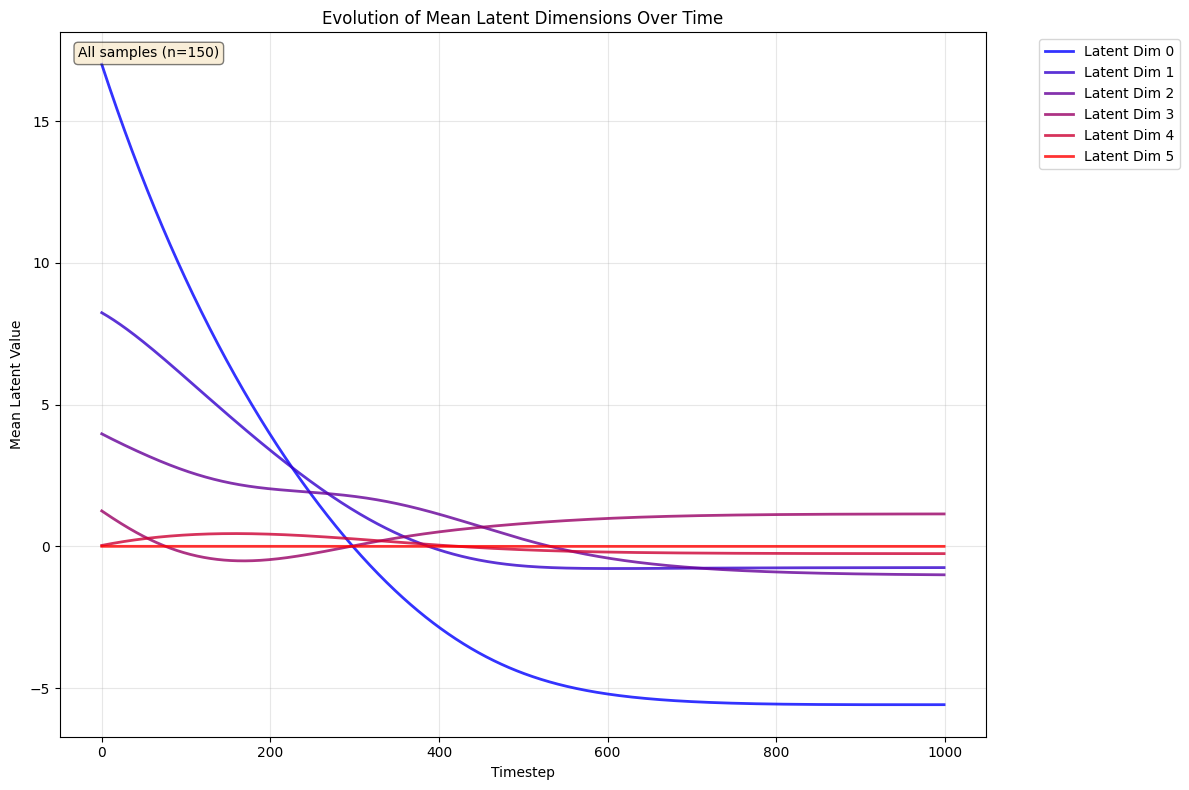

Plotted 6 latent dimensions over 1000 timesteps


In [ ]:
weights_sorted = weights[sorted_idxs]
all_sorted_weighted = all_sorted * weights_sorted.reshape(1, 1, 6)  #bias not added to center around 0.
ipynb_utils.latent_trajectory(all_sorted_weighted, sample_list=None, show=True, save=False)


# UMAP Encoding of the latent space.


c:\vscode\python\TOR-2024\ML_charge_modeling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\vscode\python\TOR-2024\ML_charge_modeling\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


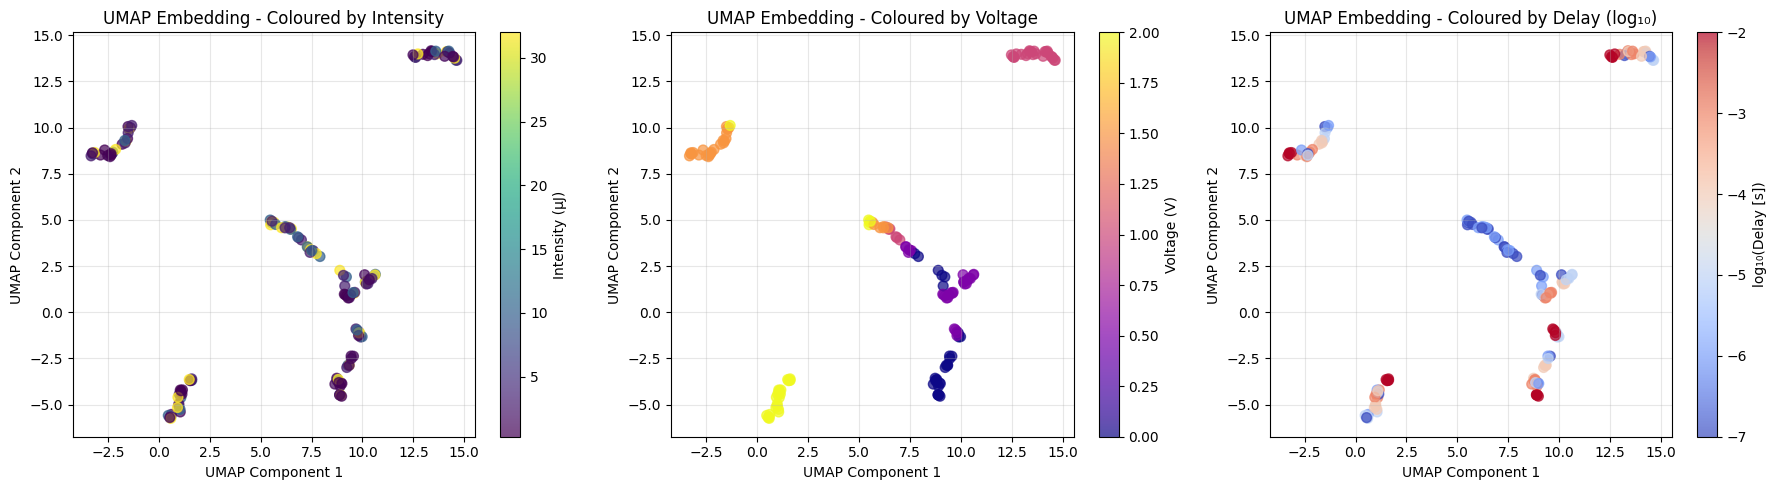

Original latent space shape: (150, 2)
UMAP embedding shape: (150, 2)
Intensity range: 0.30 to 32.00 μJ
Voltage range: 0.00 to 2.00 V
Delay range: 1.00e-07 to 1.00e-02 s
Log delay range: -7.0 to -2.0
Unique delay values: ['1.0e-07', '1.0e-06', '1.0e-05', '1.0e-04', '1.0e-03', '1.0e-02']


In [7]:
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the latent vectors
scaler = StandardScaler()
latent_scaled = scaler.fit_transform(latent)

# Apply UMAP dimensionality reduction
reducer = UMAP(n_components=2, random_state=0)
embedding = reducer.fit_transform(latent_scaled)

# Get metadata values for coloring
metadata = parameters.dataset['y'].cpu().numpy()  
intensities = [meta[0] for meta in metadata]  # INTENSITY = 0
voltages = [meta[1] for meta in metadata]     # VOLTAGE = 1
delays = [meta[2] for meta in metadata]       # DELAY = 2

# Convert delays to log scale for better visualization
log_delays = [np.log10(delay) if delay > 0 else np.nan for delay in delays]

# Create 3 subplots for intensity, voltage, and delay
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Colored by intensity
scatter1 = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=intensities, cmap='viridis', alpha=0.7, s=50)
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].set_title('UMAP Embedding - Coloured by Intensity')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0], label='Intensity (μJ)')

# Plot 2: Coloured by voltage
scatter2 = axes[1].scatter(embedding[:, 0], embedding[:, 1], c=voltages, cmap='plasma', alpha=0.7, s=50)
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].set_title('UMAP Embedding - Coloured by Voltage')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Voltage (V)')

# Plot 3: Coloured by delay (log scale)
scatter3 = axes[2].scatter(embedding[:, 0], embedding[:, 1], c=log_delays, cmap='coolwarm', alpha=0.7, s=50)
axes[2].set_xlabel('UMAP Component 1')
axes[2].set_ylabel('UMAP Component 2')
axes[2].set_title('UMAP Embedding - Coloured by Delay (log₁₀)')
axes[2].grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=axes[2], label='log₁₀(Delay [s])')

plt.tight_layout()
plt.show()

print(f"Original latent space shape: {latent.shape}")
print(f"UMAP embedding shape: {embedding.shape}")
print(f"Intensity range: {min(intensities):.2f} to {max(intensities):.2f} μJ")
print(f"Voltage range: {min(voltages):.2f} to {max(voltages):.2f} V") 
print(f"Delay range: {min([d for d in delays if d > 0]):.2e} to {max(delays):.2e} s")
print(f"Log delay range: {min([d for d in log_delays if not np.isnan(d)]):.1f} to {max([d for d in log_delays if not np.isnan(d)]):.1f}")

# Show unique delay values for reference
unique_delays = sorted(list(set([d for d in delays if d > 0])))
print(f"Unique delay values: {[f'{d:.1e}' for d in unique_delays]}")